$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 3: Convolutional Architectures
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [22]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Verify pytorch is using CUDA
print(device)

cpu


## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, convolutional layers operate on and produce volumes (3D tensors) of activations.


One way to think about them is as if the neurons are organized in a 3D grid,
where neurons at the same depth share weights (represented here as colors).
Contrary to fully connected (affine) layers, neurons in convolutional layers are **not** connected to each of the activations of the previous layer.
Instead, each neuron is connected only to a small region of the input volume e.g. a 5x5x$C_{\mathrm{in}}$ slice
(where $C_{\mathrm{in}}$ is the input volume's depth).

<img src="imgs/depthcol.jpeg" />

Another way to interpret convolutional layers is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="imgs/cnn_filters.png" width="600" />

A crucial property of convolutional layers is their translation invariance,
i.e. their ability to detect features regardelss of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ReLU)*P -> MaxPool]*(N/P) -> (Linear -> ReLU)*M -> Linear

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `hw2/models.py` module.

In [25]:
import hw2.models as models
torch.manual_seed(seed)

net = models.ConvClassifier((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_conv_out.pt').to(device)
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-5)

ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20000, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)
out = tensor([[-0

**Note about running on GPUs**.

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [26]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are therefore also on device={next(net.parameters()).device}')
print(f'The test image is therefore also on device={test_image.device}')

This notebook is running with device=cpu
The model parameter tensors are therefore also on device=cpu
The test image is therefore also on device=cpu


Let's load CIFAR-10 again to use as our dataset.

Note: If you enconter an [SSL: CERTIFICATE_VERIFY_FAILED], uncomment the below lines and run them.

In [27]:
# import ssl 
# ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
data_dir = os.path.join(os.getcwd(), '.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `hw2/training.py` module.

In [29]:
import hw2.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = models.ConvClassifier(in_size, num_classes, filters=[32], pool_every=1, hidden_dims=[100])
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(22):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.189, Accuracy 92.0): 100%|██████████| 25/25 [00:00<00:00, 34.31it/s]


## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### General notes for running experiments

- You can run the experiments on a different machine and copy the results (files)
to the `results` folder on your local machine.
This notebook will only display the results, not run the actual experiment code (except for a demo run).

- It's important to give each experiment run a name as specified by the notebook instructions later on. The each run has a `run_name` parameter that will also be the name of the results file which this notebook will expect to load.

- You will implement the code to run the experiments in the `hw2/experiments.py` module. This module has a CLI parser so that you can invoke it as a script and pass in all the configuration parameters for a single experiment run.

- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not** `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1 - Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. The feature-extraction part of our model will therefore be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->MaxPool->Conv(32,64)->ReLU->Conv(64,64)->ReLU->MaxPool
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pad_every` and `hidden_dims`. You can try some manual runs to determine some good values for the hyperparameters or implement cross-validation to do it.
However, the **dataset size** you test on should be large. Use at least ~12000 training images and ~3000 validation images. The **batch size** parameter however is also up to you.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---
test_batch (Avg. Loss 1.077, Accuracy 63.0): 100%|██████████| 834/834 [00:31<00:00, 26.51it/s]
--- EPOCH 10/10 ---
test_batch (Avg. Loss 1.079, Accuracy 62.8): 100%|██████████| 834/834 [00:32<00:00, 25.99it/s]
fit_res: FitResult(num_epochs=10, train_loss=[1.527172327041626, 1.2668099403381348, 1.1847277879714966, 1.1262290477752686, 1.0792009830474854, 1.0396780967712402, 1.004791021347046, 0.9729242324829102, 0.9431509971618652, 0.9170206785202026], train_acc=[45.48, 55.302, 58.524, 60.652, 62.276, 63.802, 65.098, 66.196, 67.19, 68.154], test_loss=[1.322577714920044, 1.2301280498504639, 1.177782654762268, 1.140730619430542, 1.1099141836166382, 1.0883005857467651, 1.0934048891067505, 1.0796318054199219, 1.0768071413040161, 1.0793519020080566], test_acc=[52.78, 56.44, 58.84, 60.34, 61.36, 62.07, 62.1, 62.63, 62.97, 62.83])
output  {'config': {'run_name': 'test_run', 'out_dir': './results', 'se

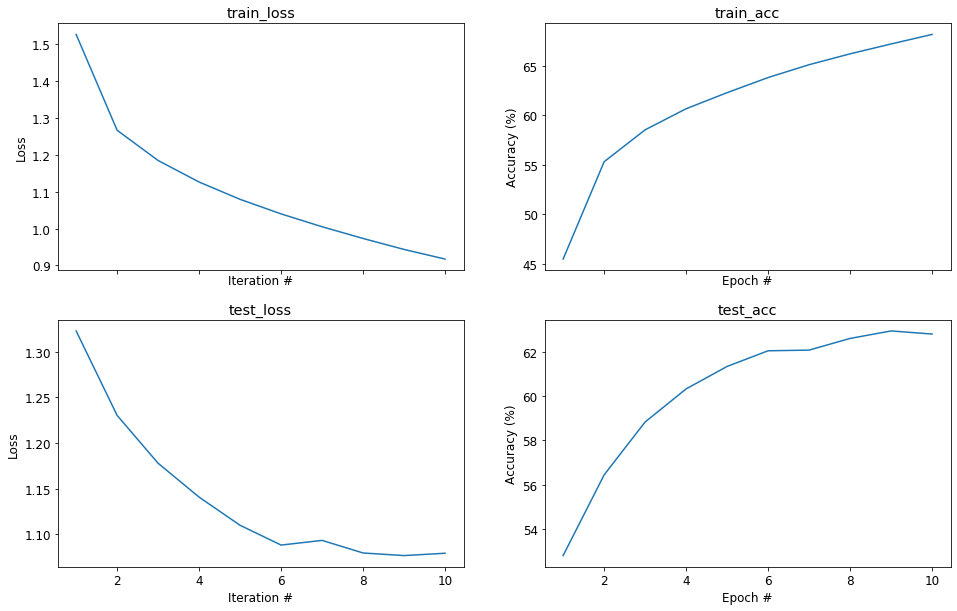

In [30]:
import hw2.experiments as experiments
from hw2.experiments import load_experiment
from helpers.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment('test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                           filters_per_layer=[32], layers_per_block=1, pool_every=1, hidden_dims=[100])

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [31]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_K{}_L{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_K32_L2`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1_K32_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


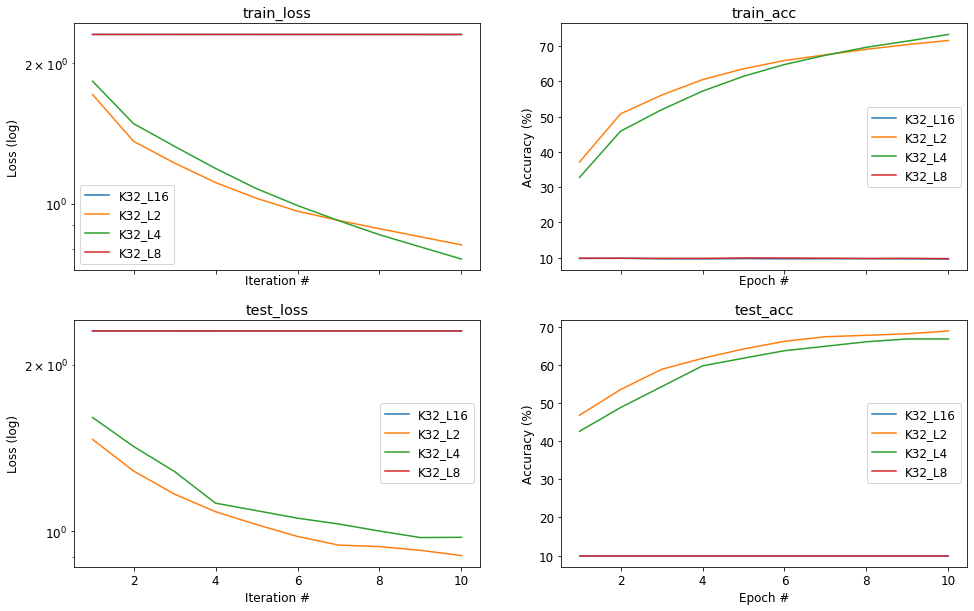

In [32]:
plot_exp_results('exp1_1_K32*.json')

common config:  {'run_name': 'exp1_1_K64_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


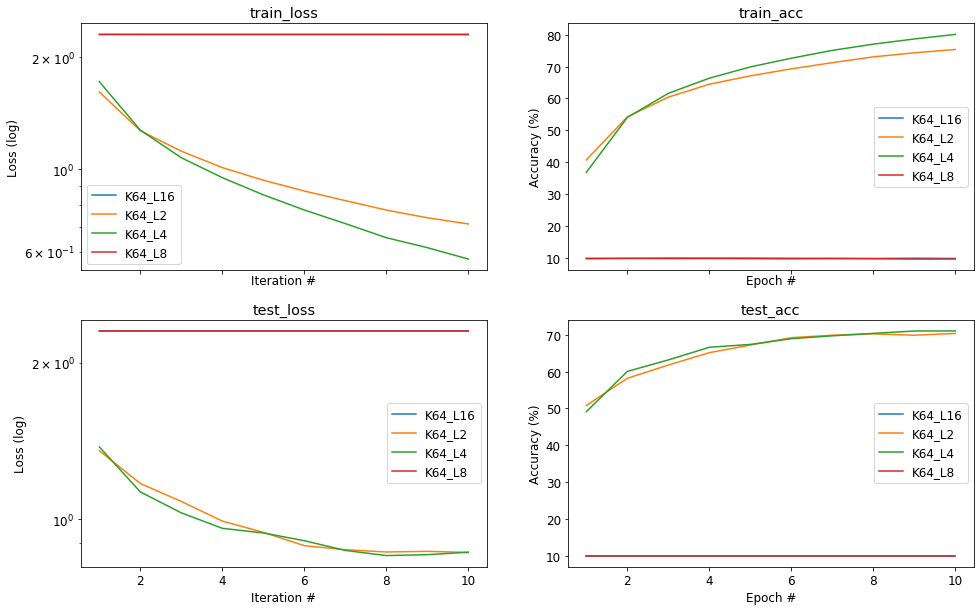

In [33]:
plot_exp_results('exp1_1_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[258]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2_L2_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


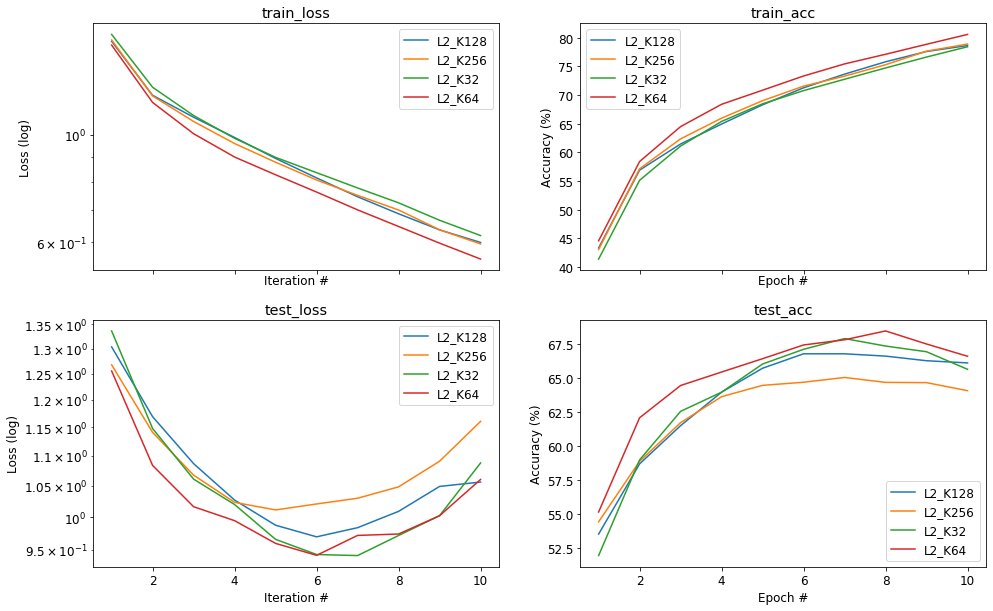

In [34]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2_L4_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


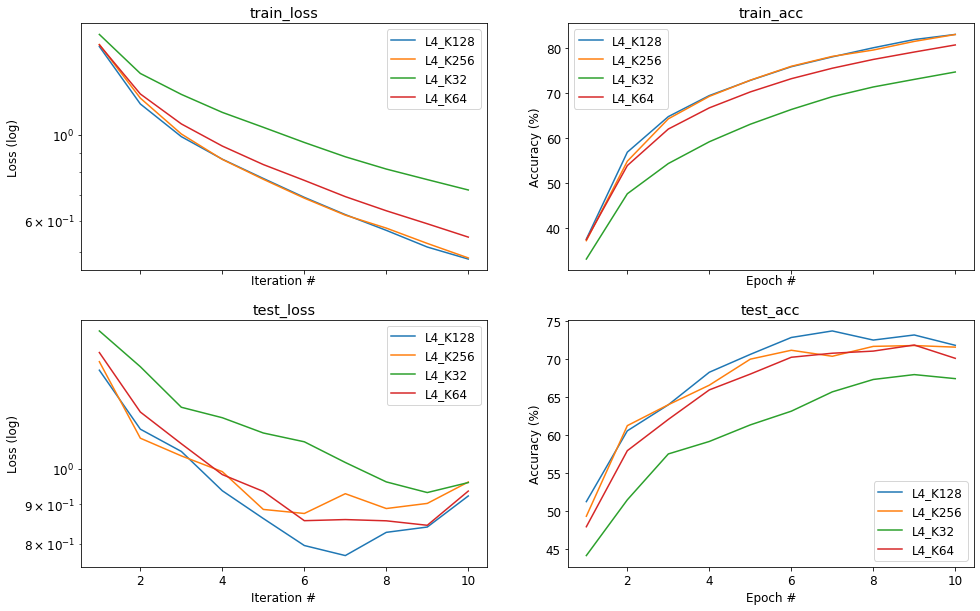

In [35]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2_L8_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


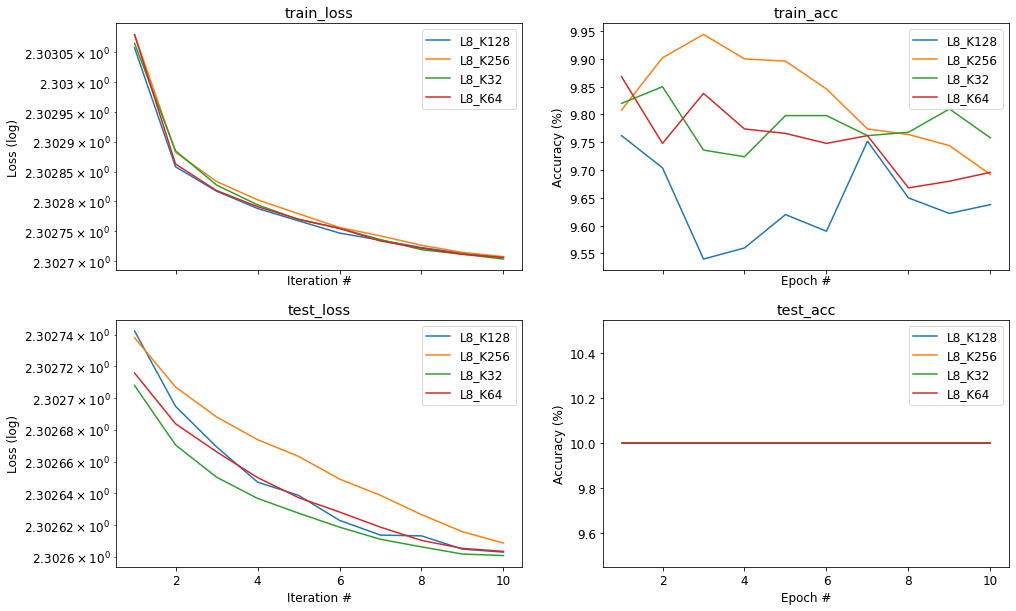

In [36]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3_L4_K64-128-256', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'ycn': False, 'kw': {}}


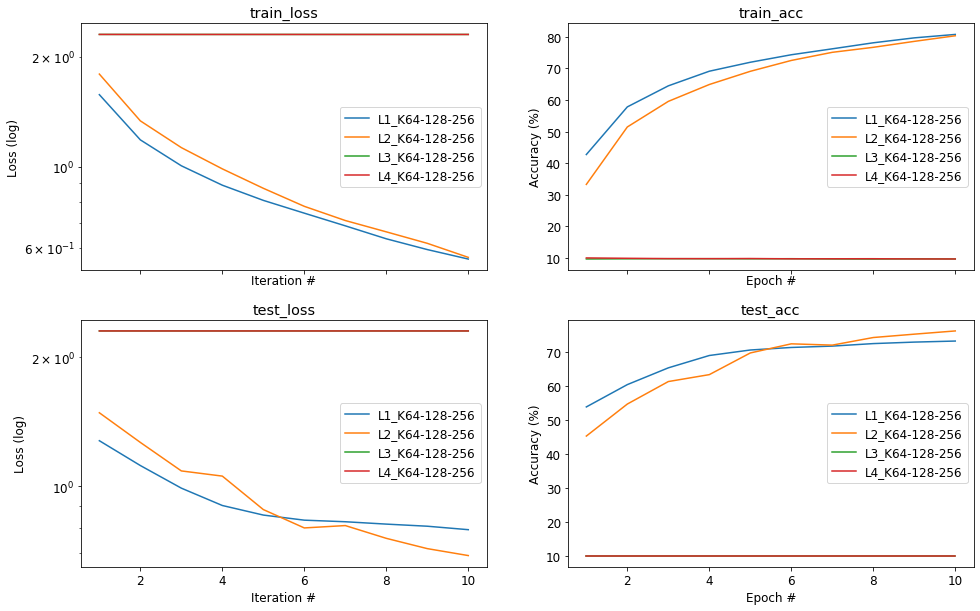

In [37]:
plot_exp_results('exp1_3*.json')

### Experiment 2 - Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures (e.g. inception module)

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw2/models.py` module.

In [38]:
net = models.YourCodeNet((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.3, inplace=False)
    (16): Bat

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[64, 128, 256, 512]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a four elements.

If you want, you can add some extra following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L1_K64-128-256-512`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results. To make the experiment runner use your custom network model instead of the previous one, use the `--ycn` argument on the command line.

common config:  {'run_name': 'exp2_L4_K64-128-256-512', 'out_dir': './results', 'seed': 42, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [512, 512], 'ycn': True, 'kw': {}}


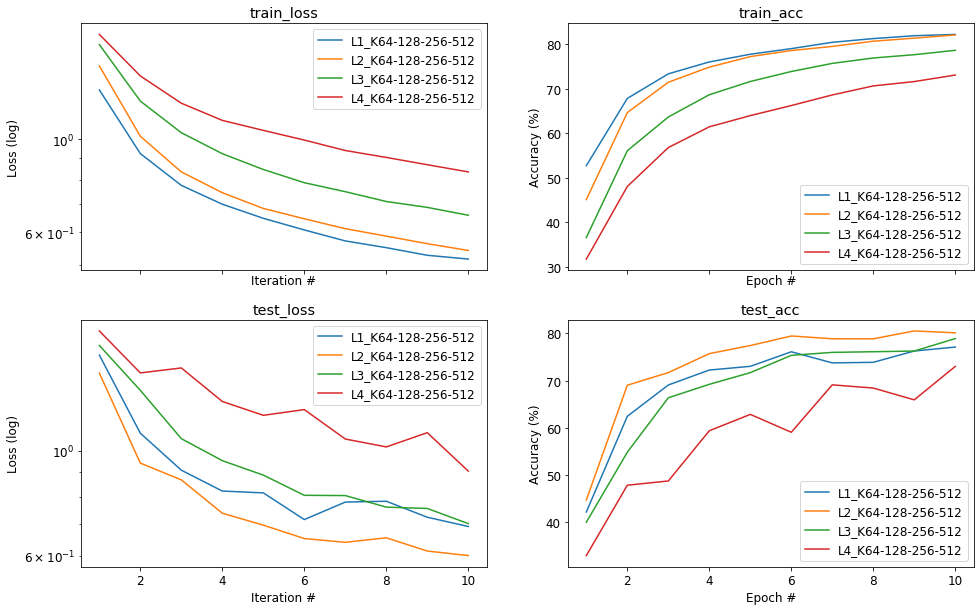

In [39]:
plot_exp_results('exp2*.json')

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [40]:
from helpers.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [41]:
display_answer(hw2.answers.part3_q1)


1. Setting L=2 leads to the highest accuracy for K=32 while setting L=4 leads to the highest accuracy for K=64.
   It seams that low L is the most suitable hyperparameter for this network since the training is stable and the loss is decreasing monotonically.
2. Setting L to 8/16 wasn't trainable - the accuracy was static (~10%) and the loss was high. As we learned in the course, it might happen due to vanishing gradients because the loss is very static.
   We can solve it by adding skip connections to the network.


### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [42]:
display_answer(hw2.answers.part3_q2)


For L=2, we can observe that K=64 achieves the best results with ~80% accuracy on the training set.
For L=4, we can see the same but with K=128.
As we saw in the previous experiment, for L=8/16 the net wasn't trainable.


### Question 3 

Analyze your results from experiment 1.3.

In [43]:
display_answer(hw2.answers.part3_q3)


We can observe that for this setting of filters, only L=1 an L=2 were trainable while L=4 wan't as opposed to previous experiments.
Also L=2 results slightly higher accuracy than L=1 on the test set though the opposite on the training set.
This means that the deeper network was less overfitted and generalizes better. 


### Question 4 

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [44]:
display_answer(hw2.answers.part3_q4)


In our custom network, we added:
1) Dropouts with p=0.5 - in order to add regularization for mitigating the overfitting
2) Batch normalization - in order to tackle the vanishing\exploding gradient
We used hidden_dims=[512,512] and filters_per_layer=[64,128,256,512].

Our architecture reflects its improvements in 2 main results:
1) We were able to train the model with L>2, as opposed to the previous experiment.
2) We achieved test accuracy of 82% which is more than 10% improvement.
